In [49]:
#Importing libraries
import pandas as pd
import os
from scipy.stats import skew
from scipy.stats import kurtosis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

In [2]:
#Loading data of Archived Users in a DataFrame
path = "D:\Major Project\Tappy data\Archived users"
os.chdir(path)

PatientName = []
PatientValues= []
columns = []

for file in os.listdir():
    if file.endswith(".txt"):
        file_path = "{}\{}".format(path,file)
 
        user_name = "{}".format(file)
        user_name = user_name[5:]
        user_name = user_name[:-4]
        PatientName.append(user_name)
        
        with open(file_path) as fp:
            lines = fp.readlines()
            curr_values = []
            
            for line in lines:
               line = line.strip()
               str = line.split(':')
               curr_values.append(str[1])
        
            PatientValues.append(curr_values)

str1 = r"\User_" + PatientName[0] + ".txt"
file_name = path + str1

with open(file_name) as fp:
    lines = fp.readlines()
    
    for line in lines:
        line = line.strip()
        str = line.split(':')
        columns.append(str[0])
        


df_users=pd.DataFrame(PatientName, columns=["User"])
df_values=pd.DataFrame(PatientValues, columns=columns)
user_info = pd.concat([df_users,df_values], axis =1)

user_info.head()
#227*13 rows



,User,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other
0,0EA27ICBLF,1952,Female,True,True,2000,Left,Don't know,Severe,True,True,False,False
1,0QAZFRHQHW,1959,Female,False,False,------,None,Don't know,------,False,False,False,False
2,0WTDIGPSBZ,1946,Female,False,False,------,None,Don't know,------,False,False,False,False
3,1HOEBIGASW,1944,Male,False,False,------,None,Don't know,------,False,False,False,False
4,1WMVCCU4RH,1953,Male,True,True,2017,Left,Don't know,Medium,False,False,False,False


In [3]:
#Loading data of Archived Data in a DataFrame
path = "D:\Major Project\Tappy data\Archived-Data"
os.chdir(path)

columns = ["User", "Date", "Timestamp", "Hand", "Hold Time", "Direction", "Latency Time", "Flight Time"]
curr_values=[]


for file in os.listdir():
    if file.endswith(".txt"):
        file_path = "{}\{}".format(path,file)
        with open(file_path) as fp:
            while True:
                line = fp.readline()
                if not line:
                    break
               
                str = line.strip()
                str1 = str.split('\t')
                curr_values.append(str1)
          
df_data=pd.DataFrame(curr_values, columns=columns)

df_data.head()
#df_data.describe()

,User,Date,Timestamp,Hand,Hold Time,Direction,Latency Time,Flight Time
0,0EA27ICBLF,160722,18:41:04.336,L,0101.6,LL,0234.4,0156.3
1,0EA27ICBLF,160722,18:42:14.070,L,0085.9,LL,0437.5,0359.4
2,0EA27ICBLF,160722,18:42:14.273,L,0078.1,LL,0210.9,0125.0
3,0EA27ICBLF,160722,18:42:14.617,L,0062.5,LL,0359.4,0281.3
4,0EA27ICBLF,160722,18:42:15.586,S,0125.0,LS,0187.5,0093.8


In [4]:
#Merging both the dataframes
final_data = pd.merge(user_info, df_data, how="inner", on="User" )
final_data.head()
final_data.describe()
print(len(pd.unique(final_data['User'])))

217


In [5]:
#Writing final dataframe to csv
final_data.to_csv(r"D:\Major Project\dataset\final_data.csv", index=False)

In [6]:
#Removing users with less than 2000 keystrokes as mentioned in the study
count=final_data['User'].value_counts()
final_data = final_data[~final_data.User.isin(count[count<2000].index)]
final_data.head()
final_data.describe()


,User,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other,Date,Timestamp,Hand,Hold Time,Direction,Latency Time,Flight Time
count,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963189,8963187
unique,131,39,2,2,2,22,3,4,5,2,2,2,2,310,6771916,190,2950,157,3422,3309
top,NPACI6EW26,,Female,True,True,------,Left,Don't know,Medium,False,False,False,False,170120,20:34:22.148,L,0078.1,LL,0203.1,0125.0
freq,1073685,1844505,5951500,6432717,5442922,2427559,4083491,8151394,3493340,5536761,6242480,8514173,6788014,99241,26,4221488,642282,1879283,193088,195186


In [7]:
#Removing rows with Impact as Severe and Medium as the study is for detecting Parkinson's at an early stage
a = [" Severe", " Medium"]
final_data = final_data[~final_data["Impact"].isin(a)]




In [8]:
count=final_data['Impact'].value_counts()
print(count)

  ------    2427559
 Mild       2258726
             177089
Name: Impact, dtype: int64


In [9]:
#Removing Users taking Levadopa to avoid any effect of the medication on other features
final_data = final_data[final_data['Levadopa'] == " False"]
final_data.head()

,User,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other,Date,Timestamp,Hand,Hold Time,Direction,Latency Time,Flight Time
207772,3MZWDTW7CC,,Female,True,False,,None,Don't know,,False,False,False,False,160921,04:32:45.801,R,0176.8,RR,0422.9,0254.9
207773,3MZWDTW7CC,,Female,True,False,,None,Don't know,,False,False,False,False,160921,04:32:46.392,L,0208.0,RL,0559.6,0382.8
207774,3MZWDTW7CC,,Female,True,False,,None,Don't know,,False,False,False,False,160921,04:32:46.912,L,0184.6,LL,0543.9,0335.9
207775,3MZWDTW7CC,,Female,True,False,,None,Don't know,,False,False,False,False,160921,04:32:47.392,L,0199.2,LL,0464.8,0280.3
207776,3MZWDTW7CC,,Female,True,False,,None,Don't know,,False,False,False,False,160921,04:33:05.762,R,0144.5,LR,0761.7,0527.3


In [10]:
final_data.Parkinsons.replace([' True', ' False'], [1, 0], inplace=True)


In [11]:
print(len(pd.unique(final_data['User'])))

53


In [12]:
print(final_data.groupby('Parkinsons')['User'].nunique())


Parkinsons
0    33
1    20
Name: User, dtype: int64


Text(0, 0.5, 'No. of male and female participants ')

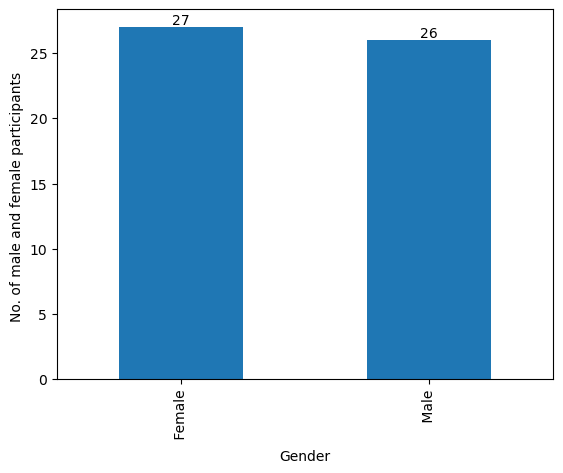

In [13]:
ax = final_data.groupby('Gender')['User'].nunique().plot(kind='bar')
ax.bar_label(ax.containers[0])
ax.set_ylabel("No. of male and female participants ")



Text(0, 0.5, "No. of participants with and without Parkinson's")

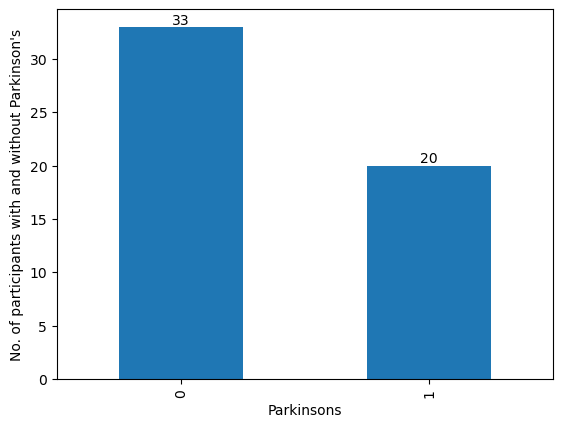

In [14]:
ax1 =final_data.groupby('Parkinsons')['User'].nunique().plot(kind='bar')
ax1.bar_label(ax1.containers[0])
ax1.set_ylabel("No. of participants with and without Parkinson's")

In [15]:
#Now we will divide the dataset into two datasets containing Hold Time features and Latency Time features

In [16]:
#Creating Hold Time dataset
groupA = final_data[['User','Hand','Hold Time']].copy()

In [17]:
#imp = SimpleImputer(missing_values=np.nan, strategy='mean', axis = 0)
#imp = imp.fit(groupA['Hold Time'])
#groupA['Hold Time'] = imp.transform(groupA['Hold Time'].values)




In [18]:
#Removing unwanted values from Hand column, filling missing values in Hold Time using mean imputation
groupA.head()
b=['L','R']
groupA=groupA[groupA['Hand'].isin(b)]
count=groupA['Hand'].value_counts()
print(count)
groupA["Hold Time"] = pd.to_numeric(groupA["Hold Time"], errors='coerce').astype(float)
groupA['Hold Time'] = groupA['Hold Time'].fillna(groupA['Hold Time'].mean())
print(groupA['Hold Time'])

L    1739400
R    1354580
Name: Hand, dtype: int64
207772     176.8
207773     208.0
207774     184.6
207775     199.2
207776     144.5
           ...  
8663204    109.4
8663205    125.0
8663206    171.9
8663207    132.8
8663208    109.4
Name: Hold Time, Length: 3093980, dtype: float64


In [19]:
#feature selecion
groupA = groupA.groupby(['User', 'Hand'])['Hold Time'].agg([np.mean, np.std, skew, kurtosis]).unstack()


In [20]:
groupA.columns= ["mean_L", "mean_R", "std_L", "std_R", "skew_L", "skew_R", "kurtosis_L", "kurtosis_R"]
groupA.head()


,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R
User,,,,,,,,
3MZWDTW7CC,170.125463,132.926297,41.532086,27.469851,0.771386,1.851463,4.305053,16.169732
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705
5PQVTWULAC,131.724002,113.398834,37.064749,29.041533,0.978465,-0.062599,7.127388,0.907739
5USOYSDCXB,72.152276,74.706504,26.076473,23.756390,0.141122,-0.265969,0.888681,1.671472
6LB9FQABZQ,126.497906,98.528074,66.799577,48.545522,0.268232,0.054373,0.026491,0.673011


In [21]:
mean_diff = groupA["mean_L"]-groupA["mean_R"]
groupA.insert(8,"mean_holdtime_diff", mean_diff)
groupA.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_holdtime_diff
User,,,,,,,,,
3MZWDTW7CC,170.125463,132.926297,41.532086,27.469851,0.771386,1.851463,4.305053,16.169732,37.199166
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175
5PQVTWULAC,131.724002,113.398834,37.064749,29.041533,0.978465,-0.062599,7.127388,0.907739,18.325168
5USOYSDCXB,72.152276,74.706504,26.076473,23.756390,0.141122,-0.265969,0.888681,1.671472,-2.554228
6LB9FQABZQ,126.497906,98.528074,66.799577,48.545522,0.268232,0.054373,0.026491,0.673011,27.969833


In [22]:
label_dataset = final_data.groupby( [ "User", "Parkinsons"] ).size().to_frame(name = 'count').reset_index()
print(label_dataset)

          User  Parkinsons   count
0   3MZWDTW7CC           1   49020
1   48DZPAJ5NS           1   12073
2   5PQVTWULAC           1    4720
3   5USOYSDCXB           1   66094
4   6LB9FQABZQ           0   34336
5   81NEUZEBXI           0   16952
6   8O9IAIA9L1           0   15072
7   9RCEHVGNCJ           0   11465
8   AVNGRDUXE5           0    4339
9   BFXNVL50DC           0   55859
10  CAXCJIKLYM           1  161135
11  COK8G1W7JY           0  416920
12  EF9XEFXPBN           1   91507
13  EMYGMAIB2L           0    4611
14  F56FSV2EP7           0    6668
15  F8KU8UP2SZ           0    6398
16  FFNMFHHSZJ           0   43827
17  G6OE5CXQPY           0  658812
18  GEYWAGTINR           0    7690
19  HAEZ2A3NM5           1   18018
20  IDYIDJBAXF           0   65138
21  JWGIQXYUDJ           0    5428
22  K2VMDST8HC           1   64363
23  LA6KW35OXK           0   79456
24  LKYPMARSKU           1   14218
25  LSQWWDXEYO           1  119290
26  M4ARHBY168           0  122379
27  MDL9KS0SFL      

In [23]:
groupA = pd.merge(groupA, label_dataset[["User", "Parkinsons"]], how="inner", on="User" )
groupA.head()

,User,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_holdtime_diff,Parkinsons
0,3MZWDTW7CC,170.125463,132.926297,41.532086,27.469851,0.771386,1.851463,4.305053,16.169732,37.199166,1
1,48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,1
2,5PQVTWULAC,131.724002,113.398834,37.064749,29.041533,0.978465,-0.062599,7.127388,0.907739,18.325168,1
3,5USOYSDCXB,72.152276,74.706504,26.076473,23.756390,0.141122,-0.265969,0.888681,1.671472,-2.554228,1
4,6LB9FQABZQ,126.497906,98.528074,66.799577,48.545522,0.268232,0.054373,0.026491,0.673011,27.969833,0


In [24]:
groupA = groupA.set_index("User")
groupA.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_holdtime_diff,Parkinsons
User,,,,,,,,,,
3MZWDTW7CC,170.125463,132.926297,41.532086,27.469851,0.771386,1.851463,4.305053,16.169732,37.199166,1
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,1
5PQVTWULAC,131.724002,113.398834,37.064749,29.041533,0.978465,-0.062599,7.127388,0.907739,18.325168,1
5USOYSDCXB,72.152276,74.706504,26.076473,23.756390,0.141122,-0.265969,0.888681,1.671472,-2.554228,1
6LB9FQABZQ,126.497906,98.528074,66.799577,48.545522,0.268232,0.054373,0.026491,0.673011,27.969833,0


In [25]:
#Creating Latency Time dataset
groupB = final_data[['User','Direction','Latency Time']].copy()

In [26]:
#Removing unwanted columns from Direction dataset
c =['LL','LR','RL','RR']
groupB=groupB[groupB['Direction'].isin(c)]
print(groupB['Direction'].value_counts())



LL    762963
RL    657685
LR    637635
RR    526562
Name: Direction, dtype: int64


In [27]:
#Filling missing values in Latency Time using mean imputation
groupB["Latency Time"] = pd.to_numeric(groupB["Latency Time"], errors='coerce').astype(float)
groupB['Latency Time'] = groupB['Latency Time'].fillna(groupB['Latency Time'].mean())
print(groupB["Latency Time"])

207772     422.9
207773     559.6
207774     543.9
207775     464.8
207776     761.7
           ...  
8663204    343.8
8663205    398.4
8663206    343.8
8663207    312.5
8663208    437.5
Name: Latency Time, Length: 2584845, dtype: float64


In [28]:
#Feature selection
groupB = groupB.groupby(['User', 'Direction'])['Latency Time'].agg([np.mean, np.std, skew, kurtosis]).unstack()


In [29]:
groupB.columns= ["mean_LL", "mean_LR", "mean_RL","mean_RR", "std_LL", "std_LR", "std_RL", "std_RR","skew_LL", "skew_LR", "skew_RL", "skew_RR", "kurtosis_LL", "kurtosis_LR", "kurtosis_RL", "kurtosis_RR"]


In [30]:
groupB.head()

,mean_LL,mean_LR,mean_RL,mean_RR,std_LL,std_LR,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR
User,,,,,,,,,,,,,,,,
3MZWDTW7CC,388.816502,387.989430,372.210366,411.115565,123.176017,137.759651,138.977302,144.442721,0.769643,0.745107,0.925719,0.426826,0.813906,0.180331,0.460611,-0.162686
48DZPAJ5NS,300.190663,335.274126,321.053098,332.504906,81.809939,81.450453,88.512695,90.989458,0.361579,0.020670,0.143658,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327
5PQVTWULAC,358.358252,478.761804,454.325847,383.152730,121.124398,128.429826,135.090148,137.104995,0.928077,-0.016904,0.386154,0.611069,2.024448,-0.323100,-0.000415,0.306093
5USOYSDCXB,177.817371,139.949558,145.719255,176.761511,85.552371,85.228366,93.083272,83.494383,1.835981,3.126761,2.885283,1.269504,8.081838,14.456914,11.615300,6.435207
6LB9FQABZQ,189.123008,186.420994,149.968216,186.735342,133.988282,148.371084,116.452677,123.530563,1.877934,1.850307,2.629422,2.052090,4.015846,3.173508,8.035135,5.091122


In [31]:
mean_diff1 = groupB["mean_LR"]-groupB["mean_RL"]
mean_diff2 = groupB["mean_LL"]-groupB["mean_RR"]
groupB.insert(16,"mean_LR_RL_diff", mean_diff1)
groupB.insert(17,"mean_LL_RR_diff", mean_diff2)
groupB.head()


,mean_LL,mean_LR,mean_RL,mean_RR,std_LL,std_LR,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff
User,,,,,,,,,,,,,,,,,,
3MZWDTW7CC,388.816502,387.989430,372.210366,411.115565,123.176017,137.759651,138.977302,144.442721,0.769643,0.745107,0.925719,0.426826,0.813906,0.180331,0.460611,-0.162686,15.779063,-22.299062
48DZPAJ5NS,300.190663,335.274126,321.053098,332.504906,81.809939,81.450453,88.512695,90.989458,0.361579,0.020670,0.143658,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242
5PQVTWULAC,358.358252,478.761804,454.325847,383.152730,121.124398,128.429826,135.090148,137.104995,0.928077,-0.016904,0.386154,0.611069,2.024448,-0.323100,-0.000415,0.306093,24.435956,-24.794478
5USOYSDCXB,177.817371,139.949558,145.719255,176.761511,85.552371,85.228366,93.083272,83.494383,1.835981,3.126761,2.885283,1.269504,8.081838,14.456914,11.615300,6.435207,-5.769697,1.055860
6LB9FQABZQ,189.123008,186.420994,149.968216,186.735342,133.988282,148.371084,116.452677,123.530563,1.877934,1.850307,2.629422,2.052090,4.015846,3.173508,8.035135,5.091122,36.452778,2.387666


In [32]:
groupB = pd.merge(groupB, label_dataset[["User", "Parkinsons"]], how="inner", on="User" )

groupB = groupB.set_index("User")

In [33]:
groupB.head()

,mean_LL,mean_LR,mean_RL,mean_RR,std_LL,std_LR,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff,Parkinsons
User,,,,,,,,,,,,,,,,,,,
3MZWDTW7CC,388.816502,387.989430,372.210366,411.115565,123.176017,137.759651,138.977302,144.442721,0.769643,0.745107,0.925719,0.426826,0.813906,0.180331,0.460611,-0.162686,15.779063,-22.299062,1
48DZPAJ5NS,300.190663,335.274126,321.053098,332.504906,81.809939,81.450453,88.512695,90.989458,0.361579,0.020670,0.143658,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242,1
5PQVTWULAC,358.358252,478.761804,454.325847,383.152730,121.124398,128.429826,135.090148,137.104995,0.928077,-0.016904,0.386154,0.611069,2.024448,-0.323100,-0.000415,0.306093,24.435956,-24.794478,1
5USOYSDCXB,177.817371,139.949558,145.719255,176.761511,85.552371,85.228366,93.083272,83.494383,1.835981,3.126761,2.885283,1.269504,8.081838,14.456914,11.615300,6.435207,-5.769697,1.055860,1
6LB9FQABZQ,189.123008,186.420994,149.968216,186.735342,133.988282,148.371084,116.452677,123.530563,1.877934,1.850307,2.629422,2.052090,4.015846,3.173508,8.035135,5.091122,36.452778,2.387666,0


In [34]:
#Dividing both the dataframes into labels and feature set
X_HT = groupA.iloc[:, 0:9].values
Y_HT = groupA.iloc[:, 9].values
X_LT = groupB.iloc[:, 0:18].values
Y_LT = groupB.iloc[:, 18].values

In [35]:
print(Y_LT)

[1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1]


In [37]:
#Calculating no. of compenents for LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=None)
X_HT_lda = lda.fit(X_HT, Y_HT)
lda_var_ratios_HT = lda.explained_variance_ratio_
lda = LinearDiscriminantAnalysis(n_components=None)

X_LT_lda = lda.fit(X_LT,Y_LT)
lda_var_ratios_LT = lda.explained_variance_ratio_

def select_n_components(var_ratio, goal_var: float) -> int:
 
    total_variance = 0.0
    n_components = 0
    
   
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1
        
       
        if total_variance >= goal_var:
            break
            
    # Return the number of components
    return n_components

select_n_components(lda_var_ratios_HT, 0.99)



1

In [38]:
select_n_components(lda_var_ratios_LT, 0.99)

1

In [39]:
#Implementing Linear Discriminant Analysis
lda = LDA(n_components=1)
X_HT = lda.fit_transform(X_HT, Y_HT)
X_LT = lda.fit_transform(X_LT, Y_LT)

#X_HT_train = lda.fit_transform(X_HT_train, y_HT_train)
#X_HT_test = lda.fit_transform(X_HT_test, y_HT_test)


In [40]:
#Splitting dataset into test and train dataset

X_HT_train, X_HT_test, y_HT_train, y_HT_test = train_test_split(X_HT, Y_HT, test_size=0.35, random_state=0)



In [41]:
X_LT_train, X_LT_test, y_LT_train, y_LT_test = train_test_split(X_LT, Y_LT, test_size=0.35, random_state=0)


In [42]:
sc = StandardScaler()
X_HT_train = sc.fit_transform(X_HT_train)
X_HT_test = sc.transform(X_HT_test)

In [43]:
sc = StandardScaler()
X_LT_train = sc.fit_transform(X_LT_train)
X_LT_test = sc.transform(X_LT_test)

In [44]:




#Feature scaling
sc = StandardScaler()
X_HT = sc.fit_transform(X_HT)
X_LT = sc.fit_transform(X_LT)

#print(X_HT, X_LT)

In [118]:
#Hyperparameter tuning for SVM using GridSeaarch CV
svc=SVC()
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]




grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           verbose=0)
grid_search.fit(X_HT, Y_HT)

print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))


# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

# calculate GridSearch CV score on test set

print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_HT, Y_HT)))



grid_search.fit(X_LT, Y_LT)

print('\n\nGridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))


# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

# calculate GridSearch CV score on test set

print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_LT, Y_LT)))


GridSearch CV best score : 0.7267


Parameters that give the best results : 

 {'C': 1000, 'gamma': 0.7, 'kernel': 'rbf'}


Estimator that was chosen by the search : 

 SVC(C=1000, gamma=0.7)
GridSearch CV score on test set: 0.7547


GridSearch CV best score : 0.8133


Parameters that give the best results : 

 {'C': 100, 'gamma': 0.9, 'kernel': 'rbf'}


Estimator that was chosen by the search : 

 SVC(C=100, gamma=0.9)
GridSearch CV score on test set: 0.8302


In [45]:
#Applying SVM using kfold CV split method using k value of 10 as mentioned in the study
svc = SVC(C= 1000, gamma=0.7, kernel= 'rbf')
svc.fit(X_HT_train, y_HT_train)
score1 = svc.score(X_HT_test, y_HT_test)
print("SVM accuracy for Group A: {:.2f}" .format(score1*100))


svc2 = SVC(C=100, gamma=0.9, kernel= 'rbf')
svc2.fit(X_LT_train, y_LT_train)
score2 = svc2.score(X_LT_test, y_LT_test)
print("SVM accuracy for Group B: {:.2f}".format(score2*100))

HT_models=list()
LT_models=list()
HT_models.append(('clf1', SVC(C= 1000, gamma=0.7, kernel= 'rbf', probability=True)))
LT_models.append(('clf1', SVC(C=100, gamma=0.9, kernel= 'rbf', probability=True)))


SVM accuracy for Group A: 84.21
SVM accuracy for Group B: 78.95


In [128]:
#Hyperparameter tuning for Logistic Regression using GridSeaarch CV

grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_HT,Y_HT)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)




logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_LT,Y_LT)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.7266666666666667
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.8099999999999999


In [50]:
#Applying Logistic Regression using kfold CV split method using k value of 10 as mentioned in the study
leg=LogisticRegression(C = 10, penalty = 'l2')

leg.fit(X_HT_train, y_HT_train)
y_HT_pred = leg.predict(X_HT_test)

print("LogReg accuracy for Group A:",accuracy_score(y_HT_test, y_HT_pred))
print("AUC score for Group A:",roc_auc_score(y_HT_test, leg.predict_proba(X_HT_test)[:, 1]))
leg=LogisticRegression(C=1, penalty = 'l2')

leg.fit(X_LT_train, y_LT_train)
y_LT_pred = leg.predict(X_LT_test)

print("LogReg accuracy for Group B:",accuracy_score(y_LT_test, y_LT_pred))
print("AUC score for Group B:", roc_auc_score(y_LT_test, leg.predict_proba(X_LT_test)[:, 1]))

HT_models.append(('clf2',LogisticRegression(C = 10, penalty = 'l2')))
LT_models.append(('clf2',LogisticRegression(C = 1, penalty = 'l2')))



LogReg accuracy for Group A: 0.8947368421052632
AUC score for Group A: 0.8846153846153847
LogReg accuracy for Group B: 0.7894736842105263
AUC score for Group B: 0.8333333333333334


In [130]:
#Hyperparameter tuning for Random Forest Classifier using GridSeaarch CV


param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5)

grid_search.fit(X_HT,Y_HT)

print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

grid_search.fit(X_LT,Y_LT)

print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
accuracy : 0.7309090909090908
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
accuracy : 0.7727272727272728


In [51]:
HT_models.append(('clf3', RandomForestClassifier(n_estimators=100)))
LT_models.append(('clf3', RandomForestClassifier(criterion = 'entropy', max_depth = 4, max_features = 'auto', n_estimators = 100)))

In [133]:
rc=RandomForestClassifier(n_estimators=100)
rc.fit(X_HT_train, y_HT_train)

y_HT_pred = rc.predict(X_HT_test)

print(accuracy_score(y_HT_test, y_HT_pred))

rc=RandomForestClassifier(criterion = 'entropy', max_depth = 4, max_features = 'auto', n_estimators = 100)
rc.fit(X_LT_train, y_LT_train)

y_LT_pred = rc.predict(X_LT_test)

print(accuracy_score(y_LT_test, y_LT_pred))

0.5789473684210527
0.7894736842105263


In [134]:
parameters = {'solver': ['lbfgs'], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
clf = GridSearchCV(MLPClassifier(), parameters, cv=5)

clf.fit(X_HT, Y_HT)

print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("accuracy :",clf.best_score_)

C:\Users\Public\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Public\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Public\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

tuned hpyerparameters :(best parameters)  {'alpha': 1e-09, 'hidden_layer_sizes': 11, 'random_state': 9, 'solver': 'lbfgs'}
accuracy : 0.7945454545454544


C:\Users\Public\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [135]:
clf.fit(X_LT, Y_LT)
print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("accuracy :",clf.best_score_)

C:\Users\Public\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Public\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Public\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

tuned hpyerparameters :(best parameters)  {'alpha': 0.01, 'hidden_layer_sizes': 14, 'random_state': 4, 'solver': 'lbfgs'}
accuracy : 0.8309090909090908


C:\Users\Public\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Public\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [52]:
#Applying Multi-layer Perceptron using kfold CV split method using k value of 10 as mentioned in the study

score = cross_val_score(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2), random_state=1), X_HT, Y_HT,cv=10)
score_lr = score.mean()
print("Multi-layer Perceptron accuracy for Group A: {:.2f}" .format(score_lr*100))


score = cross_val_score(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), X_LT, Y_LT,cv=10)
score_lr = score.mean()
print("Multi-layer Perceptron accuracy for Group B: {:.2f}" .format(score_lr*100))


HT_models.append(('clf4',MLPClassifier(solver='lbfgs', alpha=1e-09, hidden_layer_sizes=(11), random_state=9)))
LT_models.append(('clf4',MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(14), random_state=4)))


Multi-layer Perceptron accuracy for Group A: 72.67
Multi-layer Perceptron accuracy for Group B: 83.00


In [137]:
rc =MLPClassifier(solver='lbfgs', alpha=1e-09, hidden_layer_sizes=(11), random_state=9)
rc.fit(X_HT_train, y_HT_train)

y_HT_pred = rc.predict(X_HT_test)

print(accuracy_score(y_HT_test, y_HT_pred))

rc =MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(14), random_state=4)
rc.fit(X_LT_train, y_LT_train)

y_LT_pred = rc.predict(X_LT_test)

print(accuracy_score(y_LT_test, y_LT_pred))

0.47368421052631576
0.7894736842105263


In [138]:
#Hyperparameter tuning for NSVC using GridSeaarch CV
nsvc = NuSVC()
parameters = [ {'nu':[0.2, 0.5], 'kernel':['linear']},
               {'nu':[0.2, 0.5], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'nu':[0.2, 0.5], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]




grid_search = GridSearchCV(estimator = nsvc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           verbose=0)
grid_search.fit(X_HT, Y_HT)

print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))


# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

# calculate GridSearch CV score on test set

print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_HT, Y_HT)))

grid_search.fit(X_LT, Y_LT)

print('\n\nGridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))


# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

# calculate GridSearch CV score on test set

print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_LT, Y_LT)))

GridSearch CV best score : 0.6200


Parameters that give the best results : 

 {'gamma': 0.3, 'kernel': 'rbf', 'nu': 0.5}


Estimator that was chosen by the search : 

 NuSVC(gamma=0.3)
GridSearch CV score on test set: 0.6981


GridSearch CV best score : 0.8100


Parameters that give the best results : 

 {'gamma': 0.1, 'kernel': 'rbf', 'nu': 0.5}


Estimator that was chosen by the search : 

 NuSVC(gamma=0.1)
GridSearch CV score on test set: 0.8113


In [53]:
#Applying NSVC using kfold CV split method using k value of 10 as mentioned in the study



HT_models.append(('clf5',NuSVC(gamma= 0.3, kernel= 'rbf', nu= 0.5, probability=True)))
LT_models.append(('clf5',NuSVC(gamma= 0.1, kernel= 'rbf', nu= 0.5, probability=True)))

In [139]:
rc =NuSVC(gamma= 0.3, kernel= 'rbf', nu= 0.5)
rc.fit(X_HT_train, y_HT_train)

y_HT_pred = rc.predict(X_HT_test)

print(accuracy_score(y_HT_test, y_HT_pred))

rc =NuSVC(gamma= 0.1, kernel= 'rbf', nu= 0.5)
rc.fit(X_LT_train, y_LT_train)

y_LT_pred = rc.predict(X_LT_test)

print(accuracy_score(y_LT_test, y_LT_pred))

0.42105263157894735
0.8421052631578947


In [140]:
#Hyperparameter tuning for Decision Tree classifier using GridSeaarch CV
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5)
grid_search.fit(X_HT, Y_HT)

print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

grid_search.fit(X_LT, Y_LT)

print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto'}
accuracy : 0.7527272727272727
tuned hpyerparameters :(best parameters)  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto'}
accuracy : 0.8127272727272727


In [54]:
#Applying Decision Tree classifier using kfold CV split method using k value of 10 as mentioned in the study


HT_models.append(('clf6',DecisionTreeClassifier(ccp_alpha = 0.01, criterion = 'entropy', max_depth = 5, max_features= 'auto', random_state=1024)))
LT_models.append(('clf6',DecisionTreeClassifier(ccp_alpha = 0.1, criterion = 'gini', max_depth = 5, max_features= 'auto', random_state=1024)))

In [142]:
rc =DecisionTreeClassifier(ccp_alpha = 0.01, criterion = 'entropy', max_depth = 5, max_features= 'auto', random_state=1024)
rc.fit(X_HT_train, y_HT_train)

y_HT_pred = rc.predict(X_HT_test)

print(accuracy_score(y_HT_test, y_HT_pred))

rc =DecisionTreeClassifier(ccp_alpha = 0.1, criterion = 'gini', max_depth = 5, max_features= 'auto', random_state=1024)
rc.fit(X_LT_train, y_LT_train)

y_HT_pred = rc.predict(X_LT_test)

print(accuracy_score(y_LT_test, y_LT_pred))

0.5789473684210527
0.8421052631578947


In [143]:
#Hyperparameter tuning for KNN classifier using GridSeaarch CV

knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid_search.fit(X_HT, Y_HT)

print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)


grid_search.fit(X_LT, Y_LT)

print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

C:\Users\Public\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Public\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

tuned hpyerparameters :(best parameters)  {'n_neighbors': 1}
accuracy : 0.7699999999999999


C:\Users\Public\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Public\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

tuned hpyerparameters :(best parameters)  {'n_neighbors': 7}
accuracy : 0.8099999999999999


C:\Users\Public\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Public\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [55]:
#Applying KNN classifier using kfold CV split method using k value of 10 as mentioned in the study



HT_models.append(('clf7',KNeighborsClassifier(n_neighbors = 1)))
LT_models.append(('clf7',KNeighborsClassifier(n_neighbors = 7)))

In [146]:
rc = KNeighborsClassifier(n_neighbors = 1)
rc.fit(X_HT_train, y_HT_train)

y_HT_pred = rc.predict(X_HT_test)

print(accuracy_score(y_HT_test, y_HT_pred))

rc = KNeighborsClassifier(n_neighbors = 7)
rc.fit(X_LT_train, y_LT_train)

y_LT_pred = rc.predict(X_LT_test)

print(accuracy_score(y_LT_test, y_LT_pred))

0.5789473684210527
0.8421052631578947


C:\Users\Public\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Public\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [147]:
#Hyperparameter tuning for QDA classifier using GridSearch CV

params = [{'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}]
qda = QuadraticDiscriminantAnalysis()
grid_search = GridSearchCV(qda, params, cv=10)

grid_search.fit(X_HT, Y_HT)
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)


grid_search.fit(X_LT, Y_LT)

print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'reg_param': 0.1}
accuracy : 0.7233333333333333
tuned hpyerparameters :(best parameters)  {'reg_param': 0.1}
accuracy : 0.8099999999999999


In [56]:
HT_models.append(('clf8',QuadraticDiscriminantAnalysis(reg_param = 0.1)))
LT_models.append(('clf8',QuadraticDiscriminantAnalysis(reg_param = 0.1)))

In [149]:
qda = QuadraticDiscriminantAnalysis(reg_param = 0.1)
qda.fit(X_HT_train, y_HT_train)
y_HT_pred = qda.predict(X_HT_test)

print(accuracy_score(y_HT_test, y_HT_pred))

qda = QuadraticDiscriminantAnalysis(reg_param = 0.1)
qda.fit(X_LT_train, y_LT_train)
y_LT_pred = qda.predict(X_LT_test)

print(accuracy_score(y_LT_test, y_LT_pred))

0.8421052631578947
0.7894736842105263


In [150]:
print(HT_models, '\n\n',LT_models)

[('clf1', SVC(C=1000, gamma=0.7, probability=True)), ('clf2', LogisticRegression(C=10)), ('clf3', RandomForestClassifier()), ('clf4', MLPClassifier(alpha=1e-09, hidden_layer_sizes=11, random_state=9,
              solver='lbfgs')), ('clf6', DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=5,
                       max_features='auto', random_state=1024)), ('clf7', KNeighborsClassifier(n_neighbors=1)), ('clf8', QuadraticDiscriminantAnalysis(reg_param=0.1))] 

 [('clf1', SVC(C=100, gamma=0.9, probability=True)), ('clf2', LogisticRegression(C=1)), ('clf3', RandomForestClassifier(criterion='entropy', max_depth=4)), ('clf4', MLPClassifier(alpha=0.01, hidden_layer_sizes=14, random_state=4, solver='lbfgs')), ('clf6', DecisionTreeClassifier(ccp_alpha=0.1, max_depth=5, max_features='auto',
                       random_state=1024)), ('clf7', KNeighborsClassifier(n_neighbors=7)), ('clf8', QuadraticDiscriminantAnalysis(reg_param=0.1))]


In [436]:
#Finding average of all 8 ensemble models using VotingClassifier

score = cross_val_score(VotingClassifier(estimators=HT_models, voting='soft'), X_HT, Y_HT, cv=10)
score_lr = score.mean()
print("Avg accuracy for Group A: {:.2f}" .format(score_lr*100))



score = cross_val_score(VotingClassifier(estimators=LT_models, voting='soft'), X_LT, Y_LT, cv=10)
score_lr = score.mean()
print("Avg accuracy for Group B: {:.2f}" .format(score_lr*100))

Avg accuracy for Group A: 75.67


R:\ProgramFiles\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Avg accuracy for Group B: 75.33


R:\ProgramFiles\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [57]:
#For each of the Hold and Latency groups, the predicted probability results of all the models are averaged using
#a ‘mean probabilities voting classifier'
eclf1 = VotingClassifier(estimators=HT_models, voting='soft')
eclf1.fit(X_HT_train, y_HT_train)

y_HT_prob = eclf1.predict_proba(X_HT_test)
y_HT_pred = eclf1.predict(X_HT_test)
print("Accuracy of Ensemble model for each group: Group A :  {:.2f}" .format(accuracy_score(y_HT_test, y_HT_pred)*100))
score = roc_auc_score(y_HT_test, y_HT_prob[:,1])
print("AUC score : ",score)

eclf2 = VotingClassifier(estimators=LT_models, voting='soft')
eclf2.fit(X_LT_train, y_LT_train)

y_LT_prob = eclf2.predict_proba(X_LT_test)
y_LT_pred = eclf2.predict(X_LT_test)

print("Group B : {:.2f} ".format(accuracy_score(y_LT_test, y_LT_pred)*100))
score = roc_auc_score(y_LT_test, y_LT_prob[:,1])
print("AUC score : ",score)

Accuracy of Ensemble model for each group: Group A :  57.89
AUC score :  0.7051282051282051
Group B : 78.95 
AUC score :  0.7692307692307692


In [58]:
#Finally calculating the combined average probability of both the groups and predicting the results. Since Group B has a 
#higher overall accuracy we will use a weight of 1.2 for Group B probabilities, as mentioned in the study

y_LT_prob = list(map(lambda x: 0.5+(1.2*(x-0.5)), (y_LT_prob[:,1])))
pred_prob = np.stack((y_HT_prob[:,1], y_LT_prob), axis=-1)
#print(pred_prob)
y_pred = np.average(pred_prob, axis=1)
#print(y_pred)
y_hat = list(map(lambda x: 0 if x<0.5 else 1, (y_pred)))
#print(y_hat)
print("Final accuracy : {:.2f}" .format(accuracy_score(y_HT_test, y_hat)*100))


Final accuracy : 84.21


In [59]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_HT_test, y_pred)
print("AUC score : ",score)

AUC score :  0.8076923076923078
